In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
from plotly import tools
import re

import operator
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import tqdm
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='srjit', api_key='q9HR2PiI8XA1Tdh1Vrr0')

In [4]:
data = pd.read_csv("Lily.csv", delimiter=";")

In [5]:
data.head()

,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,QuotedMessage,QuotedMessageDate,QuotedMessageTime
0,2018-10-14,2018-10-14,13:13:09,18573996443,demiurge 🦇,😍😍,NaN,NaN,NaN,NaN
1,NaN,2018-10-14,13:19:27,16177355460,Lily,Hi babe,NaN,NaN,NaN,NaN
2,NaN,2018-10-14,13:19:43,18573996443,demiurge 🦇,Yaaay,NaN,NaN,NaN,NaN
3,NaN,2018-10-14,13:19:51,18573996443,demiurge 🦇,Finally she is on whatsapp,NaN,NaN,NaN,NaN
4,NaN,2018-10-14,13:19:54,18573996443,demiurge 🦇,😍😍,NaN,NaN,NaN,NaN


In [6]:
data_ = data[["Date2","Time","UserName","MessageBody"]]

In [7]:
len(data_)

59228

__About 60k messages in 10 months! Niiiiiice!__

__How many messages have we sent to each other?__

In [8]:
data.groupby("UserName").size()

UserName
Lily          25248
demiurge 🦇    33980
dtype: int64

__What is the average number of messages a person sends the other a day?__

In [9]:
data_grouped_by_day = data.groupby("Date2").size().reset_index(name="count")
data["date_"] = data.apply(lambda x: x["Date2"] + " " + x["Time"], axis=1)
data["date"] = pd.to_datetime(data["date_"])
data["week"] = data["date"].dt.week
data["month"] = data["date"].dt.month
data['day_of_week'] = data['date'].dt.weekday_name

data_grouped_by_day_of_week = data.groupby("day_of_week").size().reset_index(name="count")
data_grouped_by_week = data.groupby("week").size().reset_index(name="count")
data_grouped_by_month = data.groupby("month").size().reset_index(name="count")

__Which days do we talk most on whatsapp?__

Text(0.5, 1.0, 'Count of Messages (weekday)')

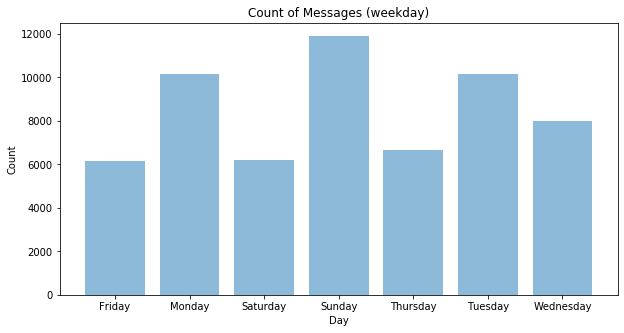

In [10]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharey=True)

ax1.bar(data_grouped_by_day_of_week["day_of_week"], data_grouped_by_day_of_week["count"], alpha=0.5)
ax1.set_xlabel('Day')
ax1.set_ylabel('Count')
ax1.set_title('Count of Messages (weekday)')

Text(0.5, 1.0, 'Count of Messages per Month')

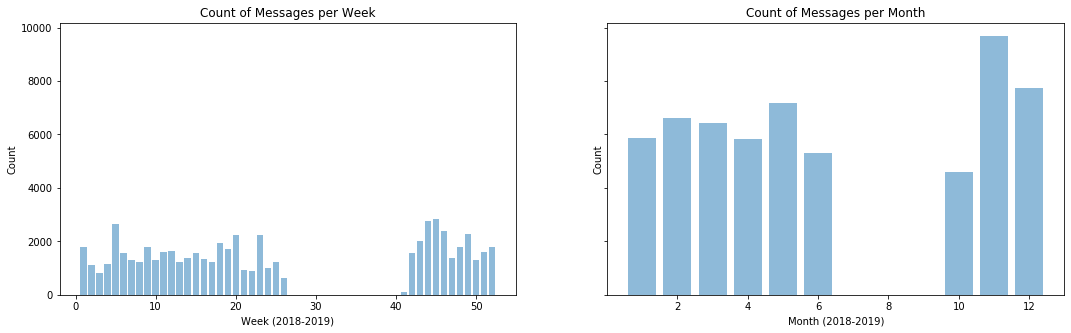

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), sharey=True)

ax1.bar(data_grouped_by_week["week"], data_grouped_by_week["count"], alpha=0.5)
ax1.set_xlabel('Week (2018-2019)')
ax1.set_ylabel('Count')
ax1.set_title('Count of Messages per Week')

ax2.bar(data_grouped_by_month["month"], data_grouped_by_month["count"], alpha=0.5)
ax2.set_xlabel('Month (2018-2019)')
ax2.set_ylabel('Count')
ax2.set_title('Count of Messages per Month')

In [12]:
data_grouped_by_day = data.groupby(["UserName","Date2"]).size().reset_index(name="count")

In [13]:
data_grouped_by_day.head()

sree = data_grouped_by_day[data_grouped_by_day.UserName != 'Lily']
lily = data_grouped_by_day[data_grouped_by_day.UserName == 'Lily']

In [14]:
trace0 = go.Scatter(
    x = sree["Date2"],
    y = sree["count"],
    mode = 'lines',
    name = 'Sree'
)

trace1 = go.Scatter(
    x = lily["Date2"],
    y = lily["count"],
    mode = 'lines',
    name = 'Lia'
)

layout = dict(title = 'Daily Messages',
              xaxis = dict(title = 'Day'),
              yaxis = dict(title = 'Count'),
              )


data0 = [trace0, trace1]

fig1 = dict(data=data0, layout=layout)
py.iplot(fig1, filename='daily-line')

In [28]:
# Dec 14 / Dec 15 - NY Trip
# Apr 24/ Apr 25/ Apr 26 - Cali Trip
# May 25 / May 26 - Maine Trip

# - all messages close to zero

## Message Analysis

In [15]:
def cleanup(line):
    word_list = line.lower().split()    
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    cleaned_text = " ".join(filtered_words)
    return cleaned_text

In [16]:
sree = data_[data_.UserName != 'Lily']
lily = data_[data_.UserName == 'Lily']

sree["text"] = sree["MessageBody"].apply(lambda x: cleanup(x))
lily["text"] = lily["MessageBody"].apply(lambda x: cleanup(x))

In [17]:
vectorizer_s = CountVectorizer()
vectorized_words_s = vectorizer_s.fit_transform(sree.text)

count_vocab_s = {value:key for key,value in vectorizer_s.vocabulary_.items()}
count_rev_dict_s = {value:key for key,value in vectorizer_s.vocabulary_.items()}
words_s = [count_rev_dict_s[i] for i in range(len(vectorizer_s.vocabulary_.keys()))]

term_frequency_s = vectorized_words_s.sum(axis=0).reshape(-1,).tolist()[0]
tf_with_index_s = {words_s[idx]: term for idx, term in enumerate(term_frequency_s)}

sum_tf_s = sum(term_frequency_s)
tf_sorted_s = sorted(tf_with_index_s.items(), key=operator.itemgetter(1), reverse=True)

word_tf_percent_s = [(tmp[0], round(tmp[1]/sum_tf_s, 3)) for tmp in tf_sorted_s]

In [18]:
vectorizer_l = CountVectorizer()
vectorized_words_l = vectorizer_l.fit_transform(lily.text)

count_vocab_l = {value:key for key,value in vectorizer_l.vocabulary_.items()}
count_rev_dict_l = {value:key for key,value in vectorizer_l.vocabulary_.items()}
words_l = [count_rev_dict_l[i] for i in range(len(vectorizer_l.vocabulary_.keys()))]

term_frequency_l = vectorized_words_l.sum(axis=0).reshape(-1,).tolist()[0]
tf_with_index_l = {words_l[idx]: term for idx, term in enumerate(term_frequency_l)}
sum_tf_l = sum(term_frequency_l)

tf_sorted_l = sorted(tf_with_index_l.items(), key=operator.itemgetter(1), reverse=True)

word_tf_percent_l = [(tmp[0], round(tmp[1]/sum_tf_l, 3)) for tmp in tf_sorted_l]

In [19]:
text_s = sree.text.str.cat(sep=" ")
text_l = lily.text.str.cat(sep=" ")

Text(0.5, 1.0, "Words from Lia's chat")

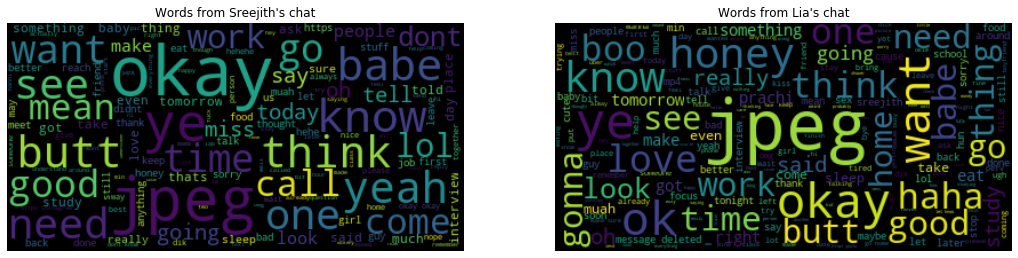

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10), sharey=True)

wordcloud1 = WordCloud(max_font_size=60).generate(text_s)
ax1.imshow(wordcloud1, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Words from Sreejith's chat")

wordcloud2 = WordCloud(max_font_size=60).generate(text_l)
ax2.imshow(wordcloud2, interpolation="bilinear")
ax2.axis("off")
ax2.set_title("Words from Lia's chat")

In [21]:
sree["date"] = pd.to_datetime(sree["Date2"])
lily["date"] = pd.to_datetime(lily["Date2"])

sree["lc"] = sree["text"].apply(lambda x: x.count("love you"))
lily["lc"] = lily["text"].apply(lambda x: x.count("love you"))

sree_tmp = sree.groupby("date")['lc'].sum().reset_index(name="count")
lily_tmp = lily.groupby("date")['lc'].sum().reset_index(name="count")

__Who said "I love you" first?__

In [22]:
trace3 = go.Scatter(
    x = sree_tmp["date"],
    y = sree_tmp["count"],
    mode = 'lines',
    name = 'Sree'
)

trace4 = go.Scatter(
    x = lily_tmp["date"],
    y = lily_tmp["count"],
    mode = 'lines',
    name = 'Lia'
)

layout = dict(xaxis = dict(title = 'Day'),
              yaxis = dict(title = 'Count'),
              title = "The `I love you` Chart!"
              )


data2 = [trace3, trace4]

fig2 = dict(data=data2, layout=layout)
py.iplot(fig2, filename='foo')

# seems about right, we said the l-word first after last year's thanksgiving!  

__What are our top favorite smilies?__

In [23]:
import emoji

def extract_emojis(str_):
    return ''.join(c for c in str_ if c in emoji.UNICODE_EMOJI)

In [24]:
emojis_s = extract_emojis(text_s)
emojis_l = extract_emojis(text_l)

# Damn! I use wayyyyy more emoticons!
len(emojis_s), len(emojis_l)

(14124, 4602)

In [25]:
emoji_counts_s = dict(Counter(emojis_s))
emoji_sorted_s = sorted(emoji_counts_s.items(), key=operator.itemgetter(1), reverse=True)
emoji_fav_s = [emoji for (emoji, count) in emoji_sorted_s]

emoji_counts_l = dict(Counter(emojis_l))
emoji_sorted_l = sorted(emoji_counts_l.items(), key=operator.itemgetter(1), reverse=True)
emoji_fav_l = [emoji for (emoji, count) in emoji_sorted_l]

__Sreejith's favorite smilies__

In [26]:
emoji_fav_s[:15]

['😘', '😂', '🙈', '🍑', '🌑', '😍', '😬', '♀', '😭', '♂', '😒', '❤', '😉', '😋', '🧝']

__Lia's favorite smilies__

In [27]:
emoji_fav_l[:15]

['😊', '😒', '😘', '😂', '😍', '😚', '🥰', '😩', '❤', '😭', '😏', '😝', '😗', '😳', '💋']